# Quantified Self | Netflix Data 
* Matt Nguyen, CPSC 222, Spring 2022
* Work on cleaning, EDA, and stats for your project

### Introduction

For this project, I will be examing my Netflix watch data from November 11th, 2017 to April 18th 2022. Albeit this is 5 years of data, I only began watching Netflix consistently during 2020, right after COVID-19 caused inital shutdowns. This data has **541 instances**, and **8 attributes**: Title, Date Viewed, Year Released, Genres, Keywords,Duration, Type, Maturity Rating. This data is in the format of **CSV**. 

Netflix data is important & interesting to me because throughout the pandemic, watching Netflix gave me something enjoyable to do & look forward to, and so, I'd like to find out further explore the numbers behind my watching, and see if I can create something unique. 

**finish this section**


* What tables (emphasis on the plural here) are included in the dataset
        * days of the week table & netflix viewing data
    * How is the data in each table collected
        * excel functions and netflix auto data collection
    * How many instances are there in each table
        * 541 in each  



* What are you trying to classify in the dataset
* What are potential impacts of the results
* Who are stakeholders interested in your results



Importing necessary libraries for this project

In [12]:
import pandas as pd 
import matplotlib.pyplot as plt
import scipy.stats as stats
# import utils

In [13]:
netflix_df = pd.read_csv("NetflixData.csv")
days_df = pd.read_csv("days_of_week.csv")

days_df_no_dups = days_df.drop_duplicates()

netflix_merged_df = netflix_df.merge(days_df_no_dups, on="Date Viewed")

# cleaning...
title_col_ser = netflix_merged_df["Title"]
cleaned_title_col_ser = title_col_ser.copy()

for i in range(0, len(title_col_ser), 1):
    curr = str(title_col_ser[i])
    if("Avatar" in curr):
        cleaned_title_col_ser[i] = "Avatar: The Last Airbender"
    else:
        cleaned_title = curr.split(":", 1)
        cleaned_title_col_ser[i] = cleaned_title[0]

netflix_merged_df["Title"] = cleaned_title_col_ser

netflix_merged_df.to_csv("NetflixMerged.csv", index=False)

### Data Analysis
* What cleaning of the dataset did you need to perform (e.g.. are there missing values and how did you handle the missing values)
    * I prepared/cleaned this dataset in a couple main ways. First, the initial downloaded csv from netflix came with only date & title. To make this data more usable for a thorough project, I added the rest of the attributes onto here manually.
* How are you merging the tables
    * merging on date viewed column 
* What are challenges with data preparation
    * although it wasn't too bad using excel, it still took a decent amount of time to manually add attributes. initally had too many rows with the merged table, so had to drop duplicates in the days_of_week table
* What data aggregation techniques are you applying
* What visualizations informatively present the attributes and relationships
* What statistical hypothesis tests are you computing
    * Make sure you set your null and alternative hypotheses up correctly. Please come see me if you have questions about how to do this


In [15]:
## Basic Stats...
duration_col_ser = netflix_merged_df["Duration"]
release_col_ser = netflix_merged_df["Year Released"]

## Duration Stats
mean_duration = duration_col_ser.mean()
total_mins_watched = duration_col_ser.sum()
frequent_duration = duration_col_ser.mode()
num_watched = len(netflix_merged_df)

# Released Yr Stats
frequent_release_yr = release_col_ser.mode()
avg_release_yr = release_col_ser.mean()

# Ratio Stats
type_count = netflix_merged_df.groupby(['Type'])['Type'].count()
length = len(netflix_merged_df)
ratio =((type_count/length)).round(3)
ratio_df = pd.DataFrame(ratio)

# trying to get the total minutes watched for each title, can't quite figure it out
# title_groupby = netflix_merged_df.groupby(['Title', 'Duration'])
# title_df = pd.DataFrame(title)

stats_list = [mean_duration, total_mins_watched, frequent_duration[0], num_watched, frequent_release_yr[0], avg_release_yr.round(3)]
stats_index = ["Average Duration", "Total Minutes Watched", "Most Frequent Duration", "Number Watched", "Most Frequent Release Year"
, "Average Release Year"]
stats_ser = pd.Series(stats_list, index=stats_index)
print(stats_ser)
print(ratio_df)


Average Duration                 26.10536
Total Minutes Watched         14123.00000
Most Frequent Duration           23.00000
Number Watched                  541.00000
Most Frequent Release Year     2015.00000
Average Release Year           2012.74100
dtype: float64
              Type
Type              
Documentary  0.004
Docuseries   0.015
Movie        0.011
TV Series    0.970


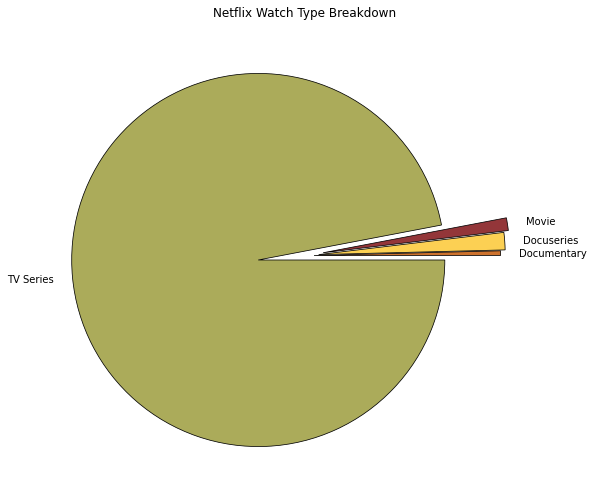

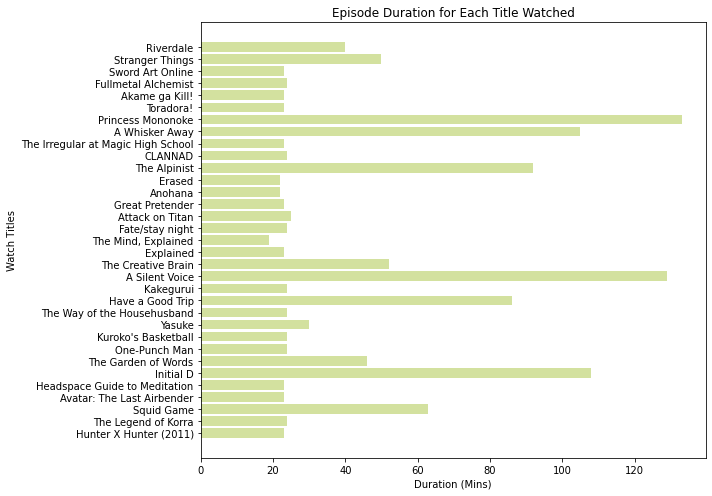

In [16]:
## Visualizations

# Type Pie Chart

colors = ("#cd722d", "#fcd053", "#933639","#abab5a")
wp = { 'linewidth' : 0.75, 'edgecolor' : "black" }
explode = (0.05, 0.075, 0.1, 0.25)

plt.figure(figsize =(10, 7))
plt.pie(ratio_df["Type"], labels = ratio_df.index, colors=colors, wedgeprops=wp, explode=explode)
plt.title("Netflix Watch Type Breakdown")
plt.tight_layout()
plt.show()

# Bar Chart
plt.figure(figsize =(10, 7))
plt.barh(cleaned_title_col_ser, netflix_merged_df["Duration"], color='#D3E19F')
plt.xlabel("Duration (Mins)")
plt.ylabel("Watch Titles")
plt.title("Episode Duration for Each Title Watched")
plt.tight_layout()
plt.show()


### Hypothesis Testing
* Looking at 2020 (the time in which I watched the most Netlix), one thing I'd like to examine is if how the summer months affected my watch time per day. Specifically, I'd like to look at how July-August potentially differed in view time to September-October. Just to be extra clear, I think my average viewing per day will be larger will be greater in the summer months than in the fall months due to not being in school at the time. 

#### Getting the necessary data

In [17]:
summer_df = netflix_merged_df.loc[264:322]
fall_df = netflix_merged_df.loc[200:258]

summer_group_df = summer_df.groupby(['Date Viewed'], as_index=False)['Duration'].sum()
fall_group_df  = fall_df.groupby(['Date Viewed'], as_index=False)['Duration'].sum()

print(summer_group_df["Duration"].sum())
print(len(summer_group_df))

print(fall_group_df["Duration"].sum())
print(len(fall_group_df))

print(len(fall_group_df) + len(summer_group_df))

1552
13
1431
23
36


Let "S" represent summer months & "F" represent fall months

1. $H_{0} : \mu_{S} = \mu_{F}$  
   $H_{1} : \mu_{S} > \mu_{F}$
2. $\alpha = 0.05$
3. Independent two-sample, one-tailed t-test
4. $t = 1.697$ (significance level of 0.05, 34 degrees of freedom, using 30 ) 
    * If $t > 1.697$, reject $H_{0}$
    * If $t < 1.697$, fail to reject $H_{0}$
5. Calculations are below: 

In [19]:
t_computed, p_value = stats.ttest_ind(fall_group_df["Duration"],summer_group_df["Duration"])
print("t-computed:", t_computed, "\np-value:", p_value/2)

t-computed: -2.863392037375321 
p-value: 0.0035649181280207483
